### New Mexico Oil Boom

https://www.eia.gov/todayinenergy/detail.php?id=54079#tab1
    
https://www.eia.gov/todayinenergy/detail.php?id=56540

https://www.eia.gov/international/overview/country/NOR

https://apnews.com/article/new-mexico-prepares-oil-collapse-c49069144d61a9a524cdd7af7616a7e7

https://www.npd.no/en/whats-new/news/production-figures/

In [117]:
# Import preliminaries
import requests
import pandas as pd
import os
import sys
sys.path.append('/home/brian/Documents/uschartbook/src/uschartbook/')

from api_key import eia_key

# Seasonal Adjustment Tools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis

# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

# Chart related
import matplotlib.pyplot as plt
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)

### Population Data

In [79]:
# Population Data 
# Norway
no = pd.read_excel('06913_20231219-150821.xlsx', header=2, 
                   index_col=1, skipfooter=43)['Population 1 January'] / 1_000
no.index = pd.to_datetime([f'{i}-01-01' for i in no.index])
gr = no.pct_change().iloc[-10:].mean()
no.loc['2024-01-01'] = no.loc['2023-01-01'] * (1 + gr)
no.name = 'Norway'

# New Mexico
nm = fred_df('NMPOP')['NMPOP']
gr = nm.pct_change().iloc[-10:].mean()
nm.loc['2023-01-01'] = nm.loc['2022-01-01'] * (1 + gr)
nm.loc['2024-01-01'] = nm.loc['2023-01-01'] * (1 + gr)
nm.name = 'New Mexico'

# Combined
pop = pd.concat([no, nm], axis=1)
pop = pop.resample('MS').interpolate()
pop.to_csv('Population_data.csv', index_label='Date')

### Oil Data

In [85]:
# Retrieve Data - New Mexico
url1 = (f'https://api.eia.gov/v2/petroleum/crd/crpdn/data/?api_key={eia_key}&'+
       'frequency=monthly&data[0]=value&facets[series][]=MCRFPNM2&'+
       'sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000')
r = requests.get(url1)

s1 = pd.Series({pd.to_datetime(f'{i["period"]}-01'): i['value'] 
       for i in r.json()['response']['data'] if i['series'] == 'MCRFPNM2'}).sort_index()
s1.name = 'New Mexico'

# Norway 
url2 = (f'https://api.eia.gov/v2/international/data/?api_key={eia_key}&'+
        'frequency=monthly&data[0]=value&facets[activityId][]=1&'+
        'facets[productId][]=57&facets[countryRegionId][]=NOR&'+
        'facets[unit][]=TBPD&sort[0][column]=period&sort[0][direction]=desc&'+
        'offset=0&length=5000')
r2 = requests.get(url2)
s2 = pd.Series({pd.to_datetime(f'{i["period"]}-01'): i['value'] 
      for i in r2.json()['response']['data']}).sort_index()

# Manually enter recent data
s2.loc['2023-06-01'] = 1818.0
s2.loc['2023-07-01'] = 1836.0
s2.loc['2023-08-01'] = 1790.0
s2.loc['2023-09-01'] = 1677.0
s2.loc['2023-10-01'] = 1777.0

# Seasonally adjust
s2 = x13_arima_analysis(s2).seasadj
s2.name = 'Norway'

# Combine and save
res = pd.concat([s1, s2], axis=1)
res.to_csv('Oil_data.csv', index_label='Date')

### Create Chart

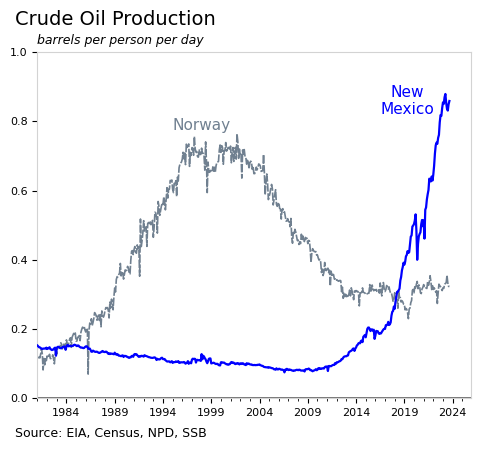

In [136]:
# Combine data and plot
pop = pd.read_csv('Population_data.csv', parse_dates=True, index_col='Date')
oil = pd.read_csv('Oil_data.csv', parse_dates=True, index_col='Date')
sh = (oil / pop).dropna()
sh.index.name = ''

# Create chart
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
styles = ['-',(0,(5,1))]
colors = ['blue', 'slategray']
linewidths = [1.6, 1.2]
zorder = [3, 2]
for col, color, ls, lw, z in zip(sh.columns, colors, styles, linewidths, zorder):
    sh[col].plot(color=color, linestyle=ls, lw=lw, ax=ax, zorder=z)

ax.set_ylim(0, 1)
ax.set_xlim('1981-01-01', '2025-12-01')
ax.axhline(0, color='dimgray', lw=2)
ax.text('1995-01-01', 0.775, 'Norway', color=colors[1], size=11)
ax.text('2019-05-01', 0.82, 'New\nMexico', color=colors[0], size=11, ha='center')

# Titles and footers
fig.text(0.04, 1.02, 'Crude Oil Production', size=14)
subtitle = ('barrels per person per day')
ax.set_title(subtitle, loc='left', size=9, style='italic')
footer = ('Source: EIA, Census, NPD, SSB')
fig.text(0.04, -0.01, footer, size=9)
plt.savefig('chart1.png', bbox_inches='tight')
plt.show()

https://www.justice.gov/ust/eo/bapcpa/20230515/bci_data/median_income_table.htm

https://www.justice.gov/ust/eo/bapcpa/20181101/bci_data/median_income_table.htm

In [137]:
# Median Family Income, 3 Person Family
url23 = 'https://www.justice.gov/ust/eo/bapcpa/20230515/bci_data/median_income_table.htm'
t = pd.read_html(url23)[1].columns.to_frame().T
t.columns = t.loc[1]
t23 = t.loc[2:].set_index('STATE')
t23.columns.name = ''
t23 = t23.replace('[\$,]', '', regex=True).astype(float)
vals = t23['3 PEOPLE'].sort_values()

In [ ]:
# State governor political party
gov = pd.read_html('https://en.wikipedia.org/wiki/List_of_current_United_States_governors')[1]
party = gov.iloc[:, [0, 4]].copy()
party.columns = ['State', 'Party']
party['STATE'] = party['State'].str.replace(' (list)', '', regex=False)
party['Key'] = party['Party'].str[0]

In [273]:
# Oil Production by state from EIA
states = pd.read_csv('states.csv')
oil22 = pd.read_csv('crude-oil-production.csv').loc[4:]
oil22.columns = ['State_ID', 'Production']
oil22 = oil22.merge(states)
oil22['Production'] = oil22['Production'] / 1_000

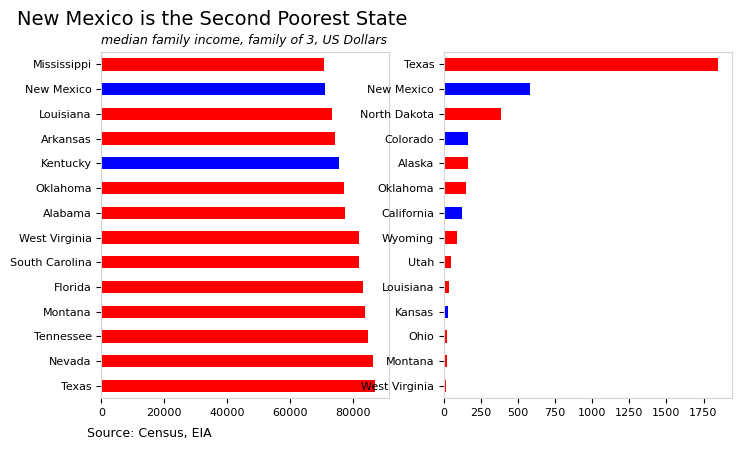

In [287]:
# Combine data
res = vals.reset_index().merge(party[['STATE', 'Key']]).merge(oil22).set_index('STATE')
res.index.name = ''
res.loc['Louisiana', 'Key'] = 'R'
res['Color'] = ['blue' if i == 'D' else 'red' for i in res['Key']]
sl = res.iloc[:14].iloc[::-1]
pr = res.sort_values(by='Production', ascending=False).iloc[:14].iloc[::-1]
# Create chart
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
fig.subplots_adjust(wspace=1.4)
plt.tight_layout()
sl['3 PEOPLE'].plot(kind='barh', color=sl['Color'], ax=ax1)
pr['Production'].plot(kind='barh', color=pr['Color'], ax=ax2)
# Titles and footers
fig.text(-0.06, 1.02, 'New Mexico is the Second Poorest State', size=14)
subtitle = ('median family income, family of 3, US Dollars')
ax1.set_title(subtitle, loc='left', size=9, style='italic')
footer = ('Source: Census, EIA')
fig.text(0.04, -0.01, footer, size=9)
plt.savefig('chart2.png', bbox_inches='tight')
plt.show()

In [267]:
res.sort_values(by='Production', ascending=False).iloc[:14]

,3 PEOPLE,Key,State_ID,Production,Color
,,,,,
Texas,87228.0,R,TX,1846806.0,red
New Mexico,71283.0,D,NM,579837.0,blue
North Dakota,93240.0,R,ND,386203.0,red
Colorado,113822.0,D,CO,160149.0,blue
Alaska,113035.0,R,AK,159611.0,red
Oklahoma,77166.0,R,OK,151537.0,red
California,104785.0,D,CA,124727.0,blue
Wyoming,93651.0,R,WY,90906.0,red
Utah,102941.0,R,UT,45251.0,red


In [256]:
vals.reset_index().merge(party[['STATE', 'Key']]).merge(oil22)

,STATE,3 PEOPLE,Key,State_ID,Production
0,Mississippi,70950.0,R,MS,12667.0
1,New Mexico,71283.0,D,NM,579837.0
2,Louisiana,73393.0,D,LA,36493.0
3,Arkansas,74475.0,R,AR,4445.0
4,Kentucky,75700.0,D,KY,2252.0
5,Oklahoma,77166.0,R,OK,151537.0
6,Alabama,77419.0,R,AL,3820.0
7,West Virginia,81964.0,R,WV,15204.0
8,South Carolina,82114.0,R,SC,0.0
9,Florida,83396.0,R,FL,1214.0


In [249]:
# Oil Production by state from EIA
states = pd.read_csv('states.csv')
oil22 = pd.read_csv('crude-oil-production.csv').loc[4:]
oil22.columns = ['State_ID', 'Production']
oil22 = oil22.merge(states)

In [250]:
states = pd.read_csv('states.csv')

In [252]:
oil22.merge(states)

,State_ID,Production,STATE
0,AL,3820.0,Alabama
1,AK,159611.0,Alaska
2,AZ,6.0,Arizona
3,AR,4445.0,Arkansas
4,CA,124727.0,California
5,CO,160149.0,Colorado
6,CT,0.0,Connecticut
7,DE,0.0,Delaware
8,DC,0.0,District of Columbia
9,FL,1214.0,Florida
